# Fig 2

Monogenic resistance can give low doses better sometimes

Heatmaps

In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [2]:
import pandas as pd

import seaborn as sns

from math import log, floor

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from xgboost import XGBRegressor
import shap
import itertools

from plots2.fns import (
    # standard_layout,
    # corner_annotations_colwise,
    # corner_annotations_rowwise,
    # get_text_annotation,
    get_corner_annotations,
    get_corner_annotations_explicit,
    get_corner_annotations_custom_labels
)

from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
)

from poly2.utils import get_dispersal_kernel, trait_vec, beta_dist, gamma_dist, Fungicide
from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture, get_asymptote_config
from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote

C:\Users\user\anaconda3\envs\poly2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
sns.set_palette("viridis_r", n_colors=10)

# Get data

In [5]:
df = pd.read_csv('../outputs/combined/fig2/fig2.csv')

In [15]:
cf = Config()

CONFIG
------
I0s = [0.00985703, 0.00985703, 0.00985703, 0.00985 ...
asymptote = None
betas = [0.00786542, 0.00786542, 0.00786542, 0.007 ...
decay_rate = None
doses = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1 ...
fungicide_mixture = False
host_on = None
k_b = 0.8431572316700577
k_mu = 9.44286788381916
l_b = 6.585357214619326
l_mu = 0.8089358816813786
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.0019836158401698102
mutation_scale_host = 0.0019836158401698102
n_k = 50
n_l = 50
n_years = 15
replace_cultivars = None
sprays = None



In [14]:
(
    df
    .groupby(['year', 's', 'r'])
    .apply(lambda x: x.loc[x.yld.idxmax()])
    .drop(['s', 'r', 'year'], axis=1)
    .reset_index()
    # .loc[lambda x: x.year==1]
    # .describe()
)

,year,s,r,yld,dose
0,1,0.005,0.265,10.504277,1.0
1,1,0.005,0.525,10.503795,1.0
2,1,0.005,0.785,10.503124,1.0
3,1,0.005,0.995,10.502395,1.0
4,1,0.015,0.265,10.478393,1.0
...,...,...,...,...,...
2075,20,0.245,0.995,9.062455,0.1
2076,20,0.255,0.265,10.149194,1.0
2077,20,0.255,0.525,9.733304,1.0
2078,20,0.255,0.785,9.250781,1.0


In [11]:
def get_df(year):
    out = (
        data
        .loc[lambda x: x.year==year]
        .set_index(['r', 's'])
        .drop('year', axis=1)
        .unstack(level=-1)    
    )

    out.columns = data.s.unique()

    return out

In [12]:
dA = get_df(5)
dB = get_df(10)
dC = get_df(15)
dD = get_df(20)

In [13]:
data.loc[lambda x: x.year.isin([5,10,15,20])].describe().loc[['min', 'max']]

dose,s,r,ratio,year
min,0.005,0.105,0.480731,5.0
max,0.905,0.995,0.519209,20.0


In [14]:
ticklabs = [0, None, None, None, None, 0.5, None, None, None, None, 1]

In [15]:
len(ticklabs)

11

In [16]:
len(data.s.unique())

10

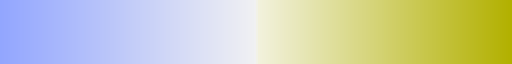

In [17]:
sns.diverging_palette(260, 85, s=100, l=70, as_cmap=True)

In [18]:
dA

,0.005,0.105,0.205,0.305,0.405,0.505,0.605,0.705,0.805,0.905
r,,,,,,,,,,
0.105,0.508801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.205,0.506511,0.517257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.305,0.502819,0.517124,0.519028,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.405,0.499558,0.516487,0.518961,0.519205,NaN,NaN,NaN,NaN,NaN,NaN
0.505,0.496703,0.514489,0.518671,0.519154,0.518364,NaN,NaN,NaN,NaN,NaN
0.605,0.493921,0.510092,0.517753,0.518960,0.518321,0.516723,NaN,NaN,NaN,NaN
0.705,0.491018,0.503249,0.515418,0.518377,0.518168,0.516683,0.514397,NaN,NaN,NaN
0.805,0.487901,0.495262,0.510665,0.516884,0.517733,0.516553,0.514360,0.511467,NaN,NaN
0.905,0.484539,0.487379,0.503106,0.513616,0.516641,0.516198,0.514244,0.511431,0.508001,NaN


In [19]:
len(data.s.unique())

10

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


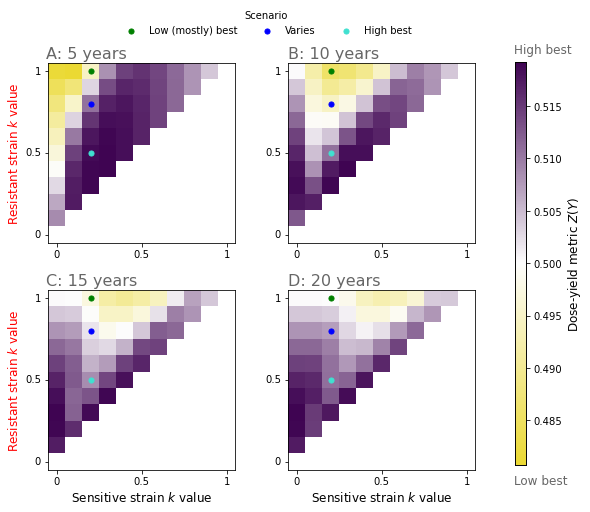

In [36]:
f, ax = plt.subplots(
    2,
    2, 
    figsize=(8,7),
)

plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT)    # legend fontsize

vmin=0.480731
vmax=0.519209

n_data = len(data.s.unique()) + 1

gg = 0.99
mid = (gg, gg, gg)
yellow1 = (0.92, 0.85, 0.2)
blue1 = (63/255,4/255, 82/255)

cvals  = [vmin, 0.5, vmax]
colors = [yellow1, mid, blue1]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm, cvals), colors))
cmap = LinearSegmentedColormap.from_list("", tuples)



cax = plt.axes([0.9, 0.1, 0.02, 0.8])

cbar_label = r'Dose-yield metric $Z(Y)$'



sns.heatmap(
    data=dA,
    ax=ax[0][0],
    center=0.5,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar_ax=cax,
    cbar_kws=dict(label=cbar_label)
)

sns.heatmap(
    data=dB,
    ax=ax[0][1],
    center=0.5,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar=False,
    cbar_ax=None,
)

sns.heatmap(
    data=dC,
    ax=ax[1][0],
    center=0.5,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar=False,
    cbar_ax=None,
)

sns.heatmap(
    data=dD,
    ax=ax[1][1],
    center=0.5,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    cbar=False,
    cbar_ax=None,
)


x1 = 2.5
y1 = 10.5-1

x2 = 2.5
y2 = 8.5-1

x3 = 2.5
y3 = 5.5-1

ss = 26

for ii, jj in itertools.product(np.arange(2), np.arange(2)):
    l1 = 'Low (mostly) best' if ii+jj==0 else None
    l2 = 'Varies' if ii+jj==0 else None
    l3 = 'High best' if ii+jj==0 else None
    
    ax[ii][jj].scatter([x1], [y1], c='g', s=ss, label=l1)
    ax[ii][jj].scatter([x2], [y2], c='b', s=ss, label=l2)
    ax[ii][jj].scatter([x3], [y3], c='turquoise', s=ss, label=l3)



ax[0][0].invert_yaxis()
ax[1][0].invert_yaxis()
ax[0][1].invert_yaxis()
ax[1][1].invert_yaxis()


ax[0][0].set_ylabel(r'Resistant strain $k$ value')
ax[1][0].set_ylabel(r'Resistant strain $k$ value')
ax[0][1].set_ylabel(None)
ax[1][1].set_ylabel(None)

ax[0][0].set_xlabel(None)
ax[1][0].set_xlabel(r'Sensitive strain $k$ value')
ax[0][1].set_xlabel(None)
ax[1][1].set_xlabel(r'Sensitive strain $k$ value')


for spine in cax.spines.values():
    spine.set(visible=True, lw=.8, edgecolor="black")

for ii, jj in itertools.product(np.arange(2), np.arange(2)):
    ax[ii][jj].spines['bottom'].set_visible(True)
    ax[ii][jj].spines['left'].set_visible(True)
    ax[ii][jj].spines['top'].set_visible(True)
    ax[ii][jj].spines['right'].set_visible(True)
    
    ax[ii][jj].set_xticks([0.5, n_data/2, n_data-0.5], minor=False)
    ax[ii][jj].set_yticks([-0.5, -1 + n_data/2, -1 + n_data-0.5], minor=False)
    
    ax[ii][jj].set_xticklabels([0, 0.5, 1], minor=False, rotation=0)
    ax[ii][jj].set_yticklabels([0, 0.5, 1], minor=False)
    
    ax[ii][jj].set_xlim([0, n_data])
    ax[ii][jj].set_ylim([-1, n_data-1])
    
    if jj==0:
        ax[ii][jj].yaxis.label.set_color('red')
        ax[ii][jj].yaxis.label.set_color('red')

f.patch.set_facecolor('white')

plt.tight_layout(rect=[0,0,0.85,0.92], h_pad=3, w_pad=3)

custom_labs = [
    'A: 5 years',
    'B: 10 years',
    'C: 15 years',
    'D: 20 years',
]

get_corner_annotations_custom_labels(2, 2, 0.08, 0.9, 0.42, 0.45, plt, custom_labs)

xx = 0.892

plt.annotate(
    'Low best',
    (xx, 0.055),
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=12,
)

plt.annotate(
    'High best',
    (xx, 0.91),
    xycoords='figure fraction',
    color=(0.4, 0.4, 0.4),
    size=12,
)

f.legend(
    loc='upper left',
    title='Scenario',
    bbox_to_anchor = (0.2,1.02),
    framealpha=0,
    ncol=3
)

## Save

In [38]:
f.savefig('../figures/paper/fig2.jpg', dpi=300, bbox_inches="tight")